# Supervised classification of a satellite image time series

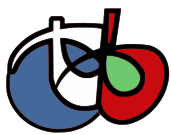

## Introduction

### Objectives
- Be able to perform a supervised classification and to measure its performance
- Know existing post-processing for classification

### Outline
This exercice will follows the following steps:
1. Single date training and spot the date with the best performance
2. Classifying and producing a colored classification map
3. Evaluate global performance
4. Classification regularization

### Mount Google Drive and OTB Installation

Mount your google drive (follow the link, allow what is needed and get the authorization code)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys

# data are assumed to be in material/02-classification/ directory, (Click on "Shared with me", Right click on "material": Add shortcut to Drive)
# otherwise modify accordingly

FOLDER = 'gdrive/My Drive/material/02-classification/'
# /!\ create corresponding folder on google drive
OUTPUT = 'gdrive/My Drive/OTB_training/output'
sys.path.append(FOLDER)

In order to install the Orfeo Toolbox you need to execute the following cells :

In [ ]:
!wget https://www.orfeo-toolbox.org/packages/OTB-7.2.0-Linux64.run
!apt-get install file

In [ ]:
!chmod +x OTB-7.2.0-Linux64.run && ./OTB-7.2.0-Linux64.run && cd OTB-7.2.0-Linux64 && ctest -S share/otb/swig/build_wrapping.cmake -VV

In [ ]:
import os, sys
os.environ["CMAKE_PREFIX_PATH"] = "/content/OTB-7.2.0-Linux64"
os.environ["OTB_APPLICATION_PATH"] = "/content/OTB-7.2.0-Linux64/lib/otb/applications"
os.environ["PATH"] = "/content/OTB-7.2.0-Linux64/bin" + os.pathsep + os.environ["PATH"]
sys.path.insert(0, "/content/OTB-7.2.0-Linux64/lib/python")
os.environ["LC_NUMERIC"] = "C"
os.environ["GDAL_DATA"] = "content/OTB-7.2.0-Linux64/share/gdal"
os.environ["PROJ_LIB"] = "/content/OTB-7.2.0-Linux64/share/proj"
os.environ["GDAL_DRIVER_PATH"] = "disable"
os.environ["OTB_MAX_RAM_HINT"] = "1000"

## Introduction to  Sentinel-2 data

- Spatial resolution: 10 meters and 20 meters

| Dates      |
|------------|
| 2016-06-07 |
| 2016-07-07 |
| 2016-08-06 |
| 2016-09-05 |
| 2016-10-05 |

- Tile: T31TCJ (extract)

| 10m    | 20m    | Band name      | S2 band id | Wavelength |
|--------|--------|----------------|------------|------------|
| Band 1 | Band 1 | Blue           | B2         | 490 nm     |
| Band 2 | Band 2 | Green          | B3         | 560 nm     |
| Band 3 | Band 3 | Red            | B4         | 665 nm     |
|        | Band 4 | NIR - Narrow 1 | B5         | 705 nm     |
|        | Band 5 | NIR - Narrow 2 | B6         | 740 nm     |
|        | Band 6 | NIR - Narrow 3 | B7         | 783 nm     |
| Band 4 |        | NIR - Wide     | B8         | 842 nm     |
|        | Band 7 | NIR - Narrow 4 | B8A        | 865 nm     |
|        | Band 8 | SWIR 1         | B11        | 1610 nm    |
|        | Band 9 | SWIR 2         | B12        | 2190 nm    |

## Supervised classification

### Classification workflow
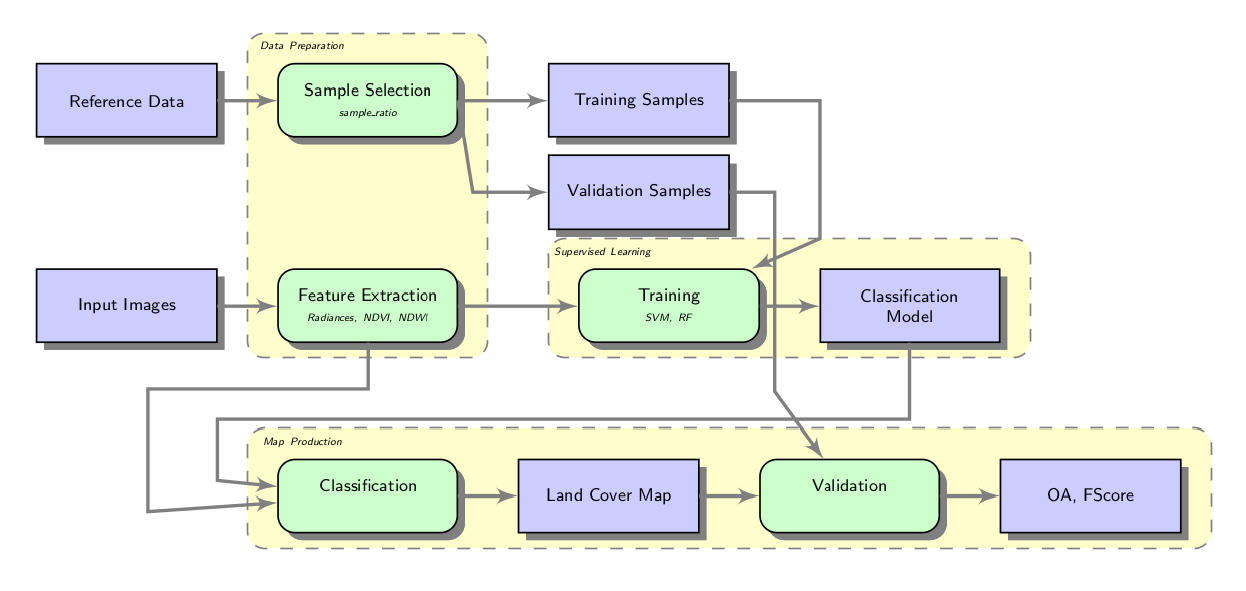

### RF algorithm 

A committee of random decision trees.

#### Learning :

1. Split the learning set in k random sets $S_k$
2. For each $S_k$, randomly choose $F_k$ features
3. Recursively build a decision tree, for each node:
    1. Choose $f \in F_k$ and the threshold $t_k$ which partitions the remaining set in two subsets as pure as possible
    2. Stop when the remaining set is too small

#### Decision
Majority vote between all random trees

### Confusion matrix
|         | Pred. 1      | Pred. 2     | Pred. 3     |
|---------|--------------|-------------|-------------|
| Ref. 1  | True pos. 1  |             |             |
| Ref. 2  |              | True pos. 2 |             |
| Ref. 3  |              |             | True pos. 3 |

- $\text{precision} = \frac{VP i}{\sum \text{pred}_i}$
- $\text{recall} = \frac{VP i}{T\sum \text{ref}_i}$
- $\text{accuracy} = \frac{\sum{VP i}}{\text{Total}}$
- $\text{kappa} = \frac{\text{accuracy} - \text{chance}}{1-\text{chance}}$

### Introduction to reference data


| Code | Name                        | #polygons training  | #polygons testing  |
|------|-----------------------------|---------------------|--------------------|
|   10 | Annual crops                | 3129                | 3078               |
|   31 | Deciduous Forests           | 176                 | 292                |
|   32 | Evergreen Forests           | 23                  | 29                 |
|   34 | Grass                       | 2                   | 2                  |
|   36 | Woody Moorlands             | 63                  | 38                 |
|   41 | Dense Urban Area            | 30                  | 33                 |
|   42 | Light Urban Area            | 326                 | 239                |
|   43 | Industrial Area             | 154                 | 212                |
|   44 | Roads                       | 162                 | 114                |
|   51 | Water                       | 243                 | 332                |
|  211 | Meadow                      | 320                 | 311                |
|  221 | Orchards                    | 227                 | 254                |
|  222 | Vineyards                   | 129                 | 97                 |

## Single date training

We are going to use the TrainImagesClassifier application in order to do supervised learning from the training date in references/training/training.shp. First, we are going to work with the image from the 07.06.2016.

The TrainImagesClassifier application will sample some image pixels within the training polygons, in order to build a well-balanced training set. This set is then passed to the learning algorithm.

This application has some mandatory parameters:
- The input images, which bands will be used as features by the learning algorithm,
- The vector layer containing references polygons,
- The name of the field in that layer that contains the class identifier,
- The output file containing the learning model (call it model.rf).

Some optional parameters should also be set as follows:
- Random forest classifier for the learning algorithm,
- The maximal tree depth to 20,
- The minimum number of samples in each node to 70,
- The number of clusters to 13 (equal to the number of classes),
- The maximum number of tree set to 50

In [1]:
# DATASET configuraiton (local execution only)
FOLDER="/home/yannick/Documents/Formation_OTB/WorkshopData/classification"
OUTPUT="/home/yannick/Documents/Formation_OTB/Output"

In [2]:
import os, sys
import otbApplication as otb

In [3]:
trainclassif = otb.Registry.CreateApplication("TrainImagesClassifier")
trainclassif.SetParameterStringList("io.il", [os.path.join(FOLDER, "images/20160607_T31TCJ_ROI_20m.tif")])
trainclassif.SetParameterStringList("io.vd", [os.path.join(FOLDER, "references/training/training.shp")])
trainclassif.SetParameterString("io.out", os.path.join(OUTPUT,"model.rf"))
trainclassif.SetParameterString("sample.vfn", "code")
trainclassif.SetParameterString("classifier", "rf")  
trainclassif.SetParameterInt("classifier.rf.nbtrees", 50)
trainclassif.SetParameterInt("classifier.rf.max", 20)
trainclassif.SetParameterInt("classifier.rf.cat", 13)
trainclassif.ExecuteAndWriteOutput()

2021-02-10 17:15:22 (INFO) TrainImagesClassifier: Default RAM limit for OTB is 256 MB
2021-02-10 17:15:22 (INFO) TrainImagesClassifier: GDAL maximum cache size is 391 MB
2021-02-10 17:15:22 (INFO) TrainImagesClassifier: OTB will use at most 8 threads
2021-02-10 17:15:22 (INFO) TrainImagesClassifier: Polygon analysis...
2021-02-10 17:15:22 (INFO) TrainImagesClassifier: Elevation management: setting default height above ellipsoid to 0 meters
2021-02-10 17:15:22 (INFO): Estimated memory for full processing: 1072.5MB (avail.: 256 MB), optimal image partitioning: 5 blocks
2021-02-10 17:15:22 (INFO): Estimation will be performed in 6 blocks of 3750x626 pixels
Analyze polygons...: 100% [**************************************************] (1s)
2021-02-10 17:15:24 (INFO) TrainImagesClassifier: Sampling rates...
2021-02-10 17:15:24 (INFO) TrainImagesClassifier: Sampling strategy : fit the number of samples based on the smallest class
2021-02-10 17:15:24 (INFO) TrainImagesClassifier: Sampling rat

0

The displayed performance is rather optimistic, since the samples used to estimate it comes from the same polygons as for the training. To obtain a more realistic evaluation of performances, it is better to select a dedicated polygon set for validation.

In [6]:
trainclassif = otb.Registry.CreateApplication("TrainImagesClassifier")
trainclassif.SetParameterStringList("io.il", [os.path.join(FOLDER, "images/20160607_T31TCJ_ROI_20m.tif")])
trainclassif.SetParameterStringList("io.vd", [os.path.join(FOLDER, "references/training/training.shp")])
trainclassif.SetParameterStringList("io.valid", [os.path.join(FOLDER, "references/testing/testing.shp")])
trainclassif.SetParameterString("io.out", os.path.join(OUTPUT,"model.rf"))
trainclassif.SetParameterString("sample.vfn", "code")
trainclassif.SetParameterString("classifier", "rf")  
trainclassif.SetParameterInt("classifier.rf.nbtrees", 50)
trainclassif.SetParameterInt("classifier.rf.max", 20)
trainclassif.SetParameterInt("classifier.rf.cat", 13)
trainclassif.SetParameterInt("cleanup", 0)
trainclassif.ExecuteAndWriteOutput()

2021-02-10 17:16:56 (INFO) TrainImagesClassifier: Default RAM limit for OTB is 256 MB
2021-02-10 17:16:56 (INFO) TrainImagesClassifier: GDAL maximum cache size is 391 MB
2021-02-10 17:16:56 (INFO) TrainImagesClassifier: OTB will use at most 8 threads
2021-02-10 17:16:56 (INFO) TrainImagesClassifier: Polygon analysis...
2021-02-10 17:16:56 (INFO) TrainImagesClassifier: Elevation management: setting default height above ellipsoid to 0 meters
2021-02-10 17:16:56 (INFO): Estimated memory for full processing: 1072.5MB (avail.: 256 MB), optimal image partitioning: 5 blocks
2021-02-10 17:16:56 (INFO): Estimation will be performed in 6 blocks of 3750x626 pixels
Analyze polygons...: 100% [**************************************************] (1s)
2021-02-10 17:16:58 (INFO) TrainImagesClassifier: Sampling rates...
2021-02-10 17:16:58 (INFO) TrainImagesClassifier: Sampling strategy : fit the number of samples based on the smallest class
2021-02-10 17:16:58 (INFO) TrainImagesClassifier: Sampling rat

0

If the cleanup option is deactivated by adding `-cleanup 0` parameter, the application does not erase temporary outputs.

The following XML files contain the statistics of available samples for each class, for training and validation set:
- model.rf_statsTrain_1.xml
- model.rf_statsValid_1.xml

The following shapefile files contain the samples used for training and for validation:
- model.rf_samplesTrain_1.shp
- model.rf_samplesValid_1.shp

Those files contain points corresponding to selected samples within the training and validation polygons. Each point has a set of fields corresponding to the radiometric measurement at the point location in the image. Those two files can be displayed in a GIS (in QGIS for instance).

### Spot the date with the best performance

The following command line allows to do the training for each date:

In [5]:
from glob import glob
from io import StringIO 
import sys

for f in glob(os.path.join(FOLDER, "images/*.tif")):
  date = os.path.basename(f).split("_")[0]
  print(f, date)
  old_stdout = sys.stdout
  result = StringIO() 
  sys.stdout = result
  trainclassif = otb.Registry.CreateApplication("TrainImagesClassifier")
  trainclassif.SetParameterStringList("io.il", [f])
  trainclassif.SetParameterStringList("io.vd", [os.path.join(FOLDER, "references/training/training.shp")])
  trainclassif.SetParameterStringList("io.valid", [os.path.join(FOLDER, "references/testing/testing.shp")])
  trainclassif.SetParameterString("io.out", os.path.join(OUTPUT,f"model_{date}.rf"))
  trainclassif.SetParameterString("sample.vfn", "code")
  trainclassif.SetParameterString("classifier", "rf")  
  trainclassif.SetParameterInt("classifier.rf.nbtrees", 50)
  trainclassif.SetParameterInt("classifier.rf.max", 20)
  trainclassif.SetParameterInt("classifier.rf.cat", 13)
  trainclassif.ExecuteAndWriteOutput()
  sys.stdout = old_stdout
  result_string = result.getvalue()
  print([l for l in result_string.split('\n') if "Kappa" in l][0])

/home/yannick/Documents/Formation_OTB/WorkshopData/classification/images/20161005_T31TCJ_ROI_20m.tif 20161005
2021-02-10 17:26:25 (INFO) TrainImagesClassifier: Global performance, Kappa index: 0.614638
/home/yannick/Documents/Formation_OTB/WorkshopData/classification/images/20160707_T31TCJ_ROI_20m.tif 20160707
2021-02-10 17:26:36 (INFO) TrainImagesClassifier: Global performance, Kappa index: 0.609304
/home/yannick/Documents/Formation_OTB/WorkshopData/classification/images/20160806_T31TCJ_ROI_20m.tif 20160806
2021-02-10 17:26:48 (INFO) TrainImagesClassifier: Global performance, Kappa index: 0.598636
/home/yannick/Documents/Formation_OTB/WorkshopData/classification/images/20160905_T31TCJ_ROI_20m.tif 20160905
2021-02-10 17:27:00 (INFO) TrainImagesClassifier: Global performance, Kappa index: 0.60703
/home/yannick/Documents/Formation_OTB/WorkshopData/classification/images/20160607_T31TCJ_ROI_20m.tif 20160607
2021-02-10 17:27:11 (INFO) TrainImagesClassifier: Global performance, Kappa index: 

We can see that the coefficient does not vary much, but that the  2016-10-05 date has slightly better performances.

### Classifying and producing a colored classification map

To perform the classification, we use the model.rf file learnt on date 2016-10-05, and use the following command line:

In [6]:
imageclassif = otb.Registry.CreateApplication("ImageClassifier")
imageclassif.SetParameterString("in", os.path.join(FOLDER, "images/20161005_T31TCJ_ROI_20m.tif"))
imageclassif.SetParameterString("out", os.path.join(OUTPUT,"classif_20161005.tif"))
imageclassif.SetParameterString("model", os.path.join(OUTPUT,"model_20161005.rf"))
imageclassif.SetParameterOutputImagePixelType("out", otb.ImagePixelType_uint8)
imageclassif.ExecuteAndWriteOutput()

2021-02-10 17:27:16 (INFO) ImageClassifier: Default RAM limit for OTB is 256 MB
2021-02-10 17:27:16 (INFO) ImageClassifier: GDAL maximum cache size is 391 MB
2021-02-10 17:27:16 (INFO) ImageClassifier: OTB will use at most 8 threads
2021-02-10 17:27:16 (INFO) ImageClassifier: Loading model
2021-02-10 17:27:17 (INFO) ImageClassifier: Model loaded
2021-02-10 17:27:17 (INFO) ImageClassifier: Input image normalization deactivated.
2021-02-10 17:27:17 (INFO): Estimated memory for full processing: 938.764MB (avail.: 256 MB), optimal image partitioning: 4 blocks
2021-02-10 17:27:17 (INFO): File /home/yannick/Documents/Formation_OTB/Output/classif_20161005.tif will be written in 5 blocks of 3750x751 pixels
Writing /home/yannick/Documents/Formation_OTB/Output/classif_20161005.tif...: 100% [**************************************************] (40s)


0

The classif_20161005.tif contains for each pixel the label of the class which has been assigned to it. In ordered to ease the visualisation of the classification result, we can transform this image by setting a different color for each class, using the ColorMapping application:

In [8]:
colormapping = otb.Registry.CreateApplication("ColorMapping")
colormapping.SetParameterString("in", os.path.join(OUTPUT,"classif_20161005.tif"))
colormapping.SetParameterString("out", os.path.join(OUTPUT,"classif_20161005_rgb.tif"))
colormapping.SetParameterOutputImagePixelType("out", otb.ImagePixelType_uint8)
colormapping.SetParameterString("method", "custom")
colormapping.SetParameterString("method.custom.lut", os.path.join(FOLDER, "support/color_map.txt"))
colormapping.ExecuteAndWriteOutput()

2021-02-10 17:28:30 (INFO) ColorMapping: Default RAM limit for OTB is 256 MB
2021-02-10 17:28:30 (INFO) ColorMapping: GDAL maximum cache size is 391 MB
2021-02-10 17:28:30 (INFO) ColorMapping: OTB will use at most 8 threads
2021-02-10 17:28:30 (INFO) ColorMapping: Color mapping with custom labeled look-up table
2021-02-10 17:28:30 (INFO) ColorMapping: Parsing color map file /home/yannick/Documents/Formation_OTB/WorkshopData/classification/support/color_map.txt.

2021-02-10 17:28:30 (INFO) ColorMapping: Adding color mapping 10 -> [218 165 32 ]

2021-02-10 17:28:30 (INFO) ColorMapping: Adding color mapping 31 -> [158 211 82 ]

2021-02-10 17:28:30 (INFO) ColorMapping: Adding color mapping 32 -> [128 211 82 ]

2021-02-10 17:28:30 (INFO) ColorMapping: Adding color mapping 34 -> [97 211 82 ]

2021-02-10 17:28:30 (INFO) ColorMapping: Adding color mapping 36 -> [82 211 97 ]

2021-02-10 17:28:30 (INFO) ColorMapping: Adding color mapping 41 -> [160 87 60 ]

2021-02-10 17:28:30 (INFO) ColorMappin

0

In [ ]:
!pip install rasterio

In [9]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

<AxesSubplot:>

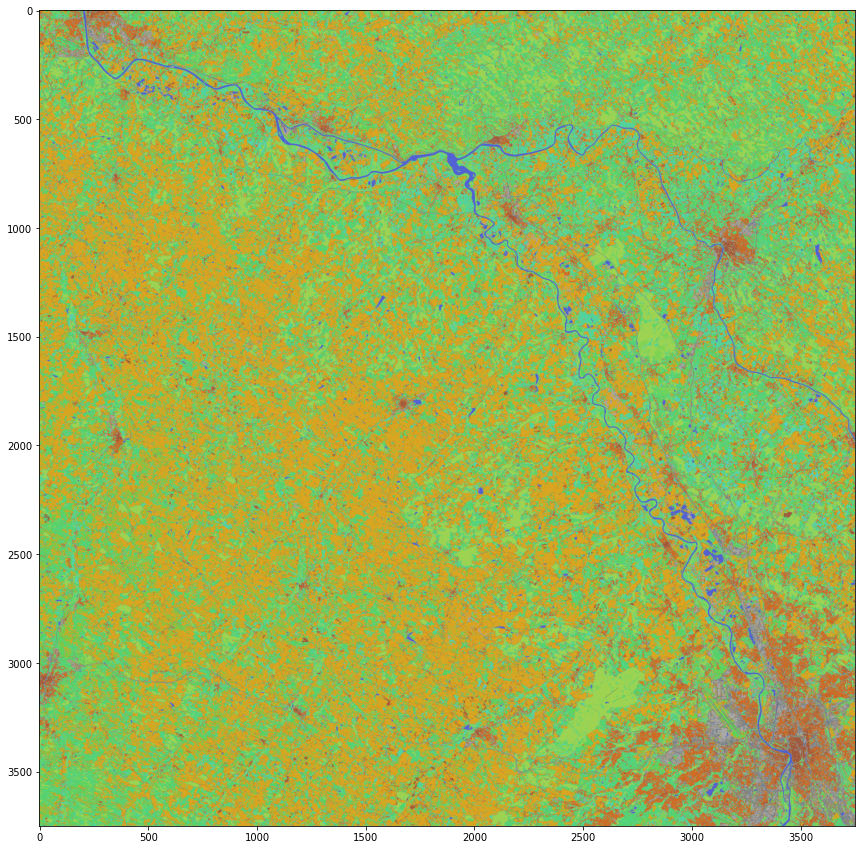

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20,15))
src = rasterio.open(os.path.join(OUTPUT,"classif_20161005_rgb.tif"))
show(src.read(), ax=ax)

Another way of displaying the classif_20161005.tif results is to open it in QGIS and use the style file provided in support/classif.qml.

### Evaluate global performance
To evaluate global performance over the whole validation set, one can use the **ComputeConfusionMatrix** application. This application allows to evaluate any classification map (for instance one that have been post-processed). Beware not to use as input the colored map created during previous step, which is only to be used for visualization purposes.

In [12]:
confusionmatrix = otb.Registry.CreateApplication("ComputeConfusionMatrix")
confusionmatrix.SetParameterString("in", os.path.join(OUTPUT,"classif_20161005.tif"))
confusionmatrix.SetParameterString("ref", "vector")
confusionmatrix.SetParameterString("ref.vector.in", os.path.join(FOLDER, "references/testing/testing.shp"))
confusionmatrix.SetParameterString("out", os.path.join(OUTPUT,"confusion_20161005.csv"))
confusionmatrix.SetParameterString("ref.vector.field", "code")
confusionmatrix.ExecuteAndWriteOutput()

2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: Default RAM limit for OTB is 256 MB
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: GDAL maximum cache size is 391 MB
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: OTB will use at most 8 threads
2021-02-10 17:29:36 (INFO): Estimated memory for full processing: 214.539MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: Number of stream divisions : 1
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: mapOfClassesRef[10] = 0
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: mapOfClassesRef[31] = 1
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: mapOfClassesRef[32] = 2
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: mapOfClassesRef[34] = 3
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: mapOfClassesRef[36] = 4
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: mapOfClassesRef[41] = 5
2021-02-10 17:29:36 (INFO) ComputeConfusionMatrix: mapOfClassesRef[42] = 6
2021-02-

0

One can note two things:
- First global performance is slightly better than the performance assessed during training. This comes from the fact that during the training step, we use the same number of samples for all classes, whereas when using the ComputeConfusionMatrix, all available samples are used. Some classes both have more available samples and are more easy to classify (such as class 51: water), and are therefore improving performances.
- Second, the annual crops class exhibit a lot of confusion with all other classes. It has a recall of 0.75 and a precision of 0.97. This means that if 97% of pixels identified as annul crops really belong to this class, 25% of pixel that belong to this class according to the reference validation set have been misclassified. We will see in last section that adding multi-temporal information in the classification allows to increase this performance.

### Classification map regularization
To regularize the classification map using a majority voting algorithm, one can use the following command line:

In [13]:
regul = otb.Registry.CreateApplication("ClassificationMapRegularization")
regul.SetParameterInt("ip.radius", 1)
regul.SetParameterInt("ip.suvbool", 0)
regul.SetParameterString("io.in", os.path.join(OUTPUT,"classif_20161005.tif"))
regul.SetParameterString("io.out", os.path.join(OUTPUT,"classif_20161005_reg.tif"))
regul.SetParameterOutputImagePixelType("io.out", otb.ImagePixelType_uint8)
regul.ExecuteAndWriteOutput()

2021-02-10 17:29:56 (INFO) ClassificationMapRegularization: Default RAM limit for OTB is 256 MB
2021-02-10 17:29:56 (INFO) ClassificationMapRegularization: GDAL maximum cache size is 391 MB
2021-02-10 17:29:56 (INFO) ClassificationMapRegularization: OTB will use at most 8 threads
2021-02-10 17:29:56 (INFO): Estimated memory for full processing: 188.829MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2021-02-10 17:29:56 (INFO): File /home/yannick/Documents/Formation_OTB/Output/classif_20161005_reg.tif will be written in 1 blocks of 3750x3750 pixels
Writing /home/yannick/Documents/Formation_OTB/Output/classif_20161005_reg.tif...: 100% [**************************************************] (1s)


0

After regularization, we can evaluate the performances of the new classification map:

In [14]:
confusionmatrix = otb.Registry.CreateApplication("ComputeConfusionMatrix")
confusionmatrix.SetParameterString("in", os.path.join(OUTPUT,"classif_20161005_reg.tif"))
confusionmatrix.SetParameterString("ref", "vector")
confusionmatrix.SetParameterString("ref.vector.in", os.path.join(FOLDER, "references/testing/testing.shp"))
confusionmatrix.SetParameterString("out", os.path.join(OUTPUT,"confusion_20161005_reg.csv"))
confusionmatrix.SetParameterString("ref.vector.field", "code")
confusionmatrix.ExecuteAndWriteOutput()

2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: Default RAM limit for OTB is 256 MB
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: GDAL maximum cache size is 391 MB
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: OTB will use at most 8 threads
2021-02-10 17:30:09 (INFO): Estimated memory for full processing: 214.539MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: Number of stream divisions : 1
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: mapOfClassesRef[10] = 0
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: mapOfClassesRef[31] = 1
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: mapOfClassesRef[32] = 2
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: mapOfClassesRef[34] = 3
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: mapOfClassesRef[36] = 4
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: mapOfClassesRef[41] = 5
2021-02-10 17:30:09 (INFO) ComputeConfusionMatrix: mapOfClassesRef[42] = 6
2021-02-

0

Regularization improves significantly the classification map performance. This is due to the fact that reference data are rather regular, and applying this processing makes the classification map look more like the reference data.

### Classification with multiple dates

We are now going to use all dates for classifications. For this, you can use the images/all.vrt which contains all bands from each date concatenated (the image has therefore 50 bands).

Lets replay the different step with all the dates altogether:

First, training:

In [15]:
trainclassif = otb.Registry.CreateApplication("TrainImagesClassifier")
trainclassif.SetParameterStringList("io.il", [os.path.join(FOLDER, "images/all.vrt")])
trainclassif.SetParameterStringList("io.vd", [os.path.join(FOLDER, "references/training/training.shp")])
trainclassif.SetParameterStringList("io.valid", [os.path.join(FOLDER, "references/testing/testing.shp")])
trainclassif.SetParameterString("io.out", os.path.join(OUTPUT,"model_all.rf"))
trainclassif.SetParameterString("sample.vfn", "code")
trainclassif.SetParameterString("classifier", "rf")  
trainclassif.SetParameterInt("classifier.rf.nbtrees", 50)
trainclassif.SetParameterInt("classifier.rf.max", 20)
trainclassif.SetParameterInt("classifier.rf.cat", 13)
trainclassif.ExecuteAndWriteOutput()

2021-02-10 17:30:28 (INFO) TrainImagesClassifier: Default RAM limit for OTB is 256 MB
2021-02-10 17:30:28 (INFO) TrainImagesClassifier: GDAL maximum cache size is 391 MB
2021-02-10 17:30:28 (INFO) TrainImagesClassifier: OTB will use at most 8 threads
2021-02-10 17:30:28 (INFO) TrainImagesClassifier: Polygon analysis...
2021-02-10 17:30:28 (INFO) TrainImagesClassifier: Elevation management: setting default height above ellipsoid to 0 meters
2021-02-10 17:30:28 (INFO): Estimated memory for full processing: 5362.51MB (avail.: 256 MB), optimal image partitioning: 21 blocks
2021-02-10 17:30:28 (INFO): Estimation will be performed in 25 blocks of 896x768 pixels
Analyze polygons...: 100% [**************************************************] (1s)
2021-02-10 17:30:30 (INFO) TrainImagesClassifier: Sampling rates...
2021-02-10 17:30:30 (INFO) TrainImagesClassifier: Sampling strategy : fit the number of samples based on the smallest class
2021-02-10 17:30:30 (INFO) TrainImagesClassifier: Sampling r

0

Then, classification:

In [16]:
imageclassif = otb.Registry.CreateApplication("ImageClassifier")
imageclassif.SetParameterString("in", os.path.join(FOLDER, "images/all.vrt"))
imageclassif.SetParameterString("out", os.path.join(OUTPUT,"classif_all.tif"))
imageclassif.SetParameterString("model", os.path.join(OUTPUT,"model_all.rf"))
imageclassif.SetParameterOutputImagePixelType("out", otb.ImagePixelType_uint8)
imageclassif.ExecuteAndWriteOutput()

2021-02-10 17:31:21 (INFO) ImageClassifier: Default RAM limit for OTB is 256 MB
2021-02-10 17:31:21 (INFO) ImageClassifier: GDAL maximum cache size is 391 MB
2021-02-10 17:31:21 (INFO) ImageClassifier: OTB will use at most 8 threads
2021-02-10 17:31:21 (INFO) ImageClassifier: Loading model
2021-02-10 17:31:21 (INFO) ImageClassifier: Model loaded
2021-02-10 17:31:21 (INFO) ImageClassifier: Input image normalization deactivated.
2021-02-10 17:31:21 (INFO): Estimated memory for full processing: 3084.53MB (avail.: 256 MB), optimal image partitioning: 13 blocks
2021-02-10 17:31:21 (INFO): File /home/yannick/Documents/Formation_OTB/Output/classif_all.tif will be written in 16 blocks of 1152x1024 pixels
Writing /home/yannick/Documents/Formation_OTB/Output/classif_all.tif...: 100% [**************************************************] (37s)


0

Next, regularisation:

In [17]:
regul = otb.Registry.CreateApplication("ClassificationMapRegularization")
regul.SetParameterInt("ip.radius", 1)
regul.SetParameterInt("ip.suvbool", 0)
regul.SetParameterString("io.in", os.path.join(OUTPUT,"classif_all.tif"))
regul.SetParameterString("io.out", os.path.join(OUTPUT,"classif_all_reg.tif"))
regul.SetParameterOutputImagePixelType("io.out", otb.ImagePixelType_uint8)
regul.ExecuteAndWriteOutput()

2021-02-10 17:31:58 (INFO) ClassificationMapRegularization: Default RAM limit for OTB is 256 MB
2021-02-10 17:31:58 (INFO) ClassificationMapRegularization: GDAL maximum cache size is 391 MB
2021-02-10 17:31:58 (INFO) ClassificationMapRegularization: OTB will use at most 8 threads
2021-02-10 17:31:58 (INFO): Estimated memory for full processing: 188.829MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2021-02-10 17:31:58 (INFO): File /home/yannick/Documents/Formation_OTB/Output/classif_all_reg.tif will be written in 1 blocks of 3750x3750 pixels
Writing /home/yannick/Documents/Formation_OTB/Output/classif_all_reg.tif...: 100% [**************************************************] (1s)


0

Finally, evaluation of performances:

In [18]:
confusionmatrix = otb.Registry.CreateApplication("ComputeConfusionMatrix")
confusionmatrix.SetParameterString("in", os.path.join(OUTPUT,"classif_all_reg.tif"))
confusionmatrix.SetParameterString("ref", "vector")
confusionmatrix.SetParameterString("ref.vector.in", os.path.join(FOLDER, "references/testing/testing.shp"))
confusionmatrix.SetParameterString("out", os.path.join(OUTPUT,"confusion_all_reg.csv"))
confusionmatrix.SetParameterString("ref.vector.field", "code")
confusionmatrix.ExecuteAndWriteOutput()

2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: Default RAM limit for OTB is 256 MB
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: GDAL maximum cache size is 391 MB
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: OTB will use at most 8 threads
2021-02-10 17:32:05 (INFO): Estimated memory for full processing: 214.539MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: Number of stream divisions : 1
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: mapOfClassesRef[10] = 0
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: mapOfClassesRef[31] = 1
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: mapOfClassesRef[32] = 2
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: mapOfClassesRef[34] = 3
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: mapOfClassesRef[36] = 4
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: mapOfClassesRef[41] = 5
2021-02-10 17:32:05 (INFO) ComputeConfusionMatrix: mapOfClassesRef[42] = 6
2021-02-

0

Adding multi-temporal information in classification result in a significant performance improvement. One can note that recall of the annual crops class has raised to 93%, which means that now 93% of this class in the ground truth are correctly classified. This improvement was expected since crop classes usually have a strong temporal signature with respect to other classes.

Finally, we can generate the color classification map:

In [19]:
colormapping = otb.Registry.CreateApplication("ColorMapping")
colormapping.SetParameterString("in", os.path.join(OUTPUT,"classif_all_reg.tif"))
colormapping.SetParameterString("out", os.path.join(OUTPUT,"classif_all_reg_rgb.tif"))
colormapping.SetParameterOutputImagePixelType("out", otb.ImagePixelType_uint8)
colormapping.SetParameterString("method", "custom")
colormapping.SetParameterString("method.custom.lut", os.path.join(FOLDER, "support/color_map.txt"))
colormapping.ExecuteAndWriteOutput()

2021-02-10 17:32:13 (INFO) ColorMapping: Default RAM limit for OTB is 256 MB
2021-02-10 17:32:13 (INFO) ColorMapping: GDAL maximum cache size is 391 MB
2021-02-10 17:32:13 (INFO) ColorMapping: OTB will use at most 8 threads
2021-02-10 17:32:13 (INFO) ColorMapping: Color mapping with custom labeled look-up table
2021-02-10 17:32:13 (INFO) ColorMapping: Parsing color map file /home/yannick/Documents/Formation_OTB/WorkshopData/classification/support/color_map.txt.

2021-02-10 17:32:13 (INFO) ColorMapping: Adding color mapping 10 -> [218 165 32 ]

2021-02-10 17:32:13 (INFO) ColorMapping: Adding color mapping 31 -> [158 211 82 ]

2021-02-10 17:32:13 (INFO) ColorMapping: Adding color mapping 32 -> [128 211 82 ]

2021-02-10 17:32:13 (INFO) ColorMapping: Adding color mapping 34 -> [97 211 82 ]

2021-02-10 17:32:13 (INFO) ColorMapping: Adding color mapping 36 -> [82 211 97 ]

2021-02-10 17:32:13 (INFO) ColorMapping: Adding color mapping 41 -> [160 87 60 ]

2021-02-10 17:32:13 (INFO) ColorMappin

0

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,15))
src = rasterio.open("classif_all_reg_rgb.tif")
show(src.read(), ax=ax)